In [1]:
%%capture
!pip3 install -q -U jax jaxlib flax imageio-ffmpeg wandb

import os
import time
import wandb
import imageio
import requests
from typing import Any
import ipywidgets as widgets
from functools import partial
from tqdm.notebook import tqdm
from kaggle_secrets import UserSecretsClient

import jax
import flax
import optax
from jax import lax
import flax.linen as nn
from flax.training import train_state, common_utils

import numpy as np
import jax.numpy as jnp

from base64 import b64encode
from IPython.display import HTML
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
os.environ['WANDB_API_KEY'] = UserSecretsClient().get_secret("wandb_api_key")
wandb.init(project="nerf-jax", job_type="test")

config = wandb.config
config.near_bound = 2.
config.far_bound = 6.
config.batch_size = int(1e4)
config.num_sample_points = 256
config.epsilon = 1e10
config.positional_encoding_dims = 6
config.num_dense_layers = 8
config.dense_layer_width = 256
config.learning_rate = 5e-4
config.train_epochs = 1000
config.plot_interval = 200

wandb: Currently logged in as: sanazhesaraki1369. Use `wandb login --relogin` to force relogin


In [3]:
# Reference: https://www.kaggle.com/code/odins0n/jax-flax-tf-data-vision-transformers-tutorial

if 'TPU_NAME' in os.environ:
    import requests
    if 'TPU_DRIVER_MODE' not in globals():
        url = 'http:' + os.environ['TPU_NAME'].split(':')[1] + ':8475/requestversion/tpu_driver_nightly'
        resp = requests.post(url)
        TPU_DRIVER_MODE = 1
    from jax.config import config as jax_config
    jax_config.FLAGS.jax_xla_backend = "tpu_driver"
    jax_config.FLAGS.jax_backend_target = os.environ['TPU_NAME']
    print("TPU DETECTED!")
    print('Registered TPU:', jax_config.FLAGS.jax_backend_target)
elif "COLAB_TPU_ADDR" in os.environ:
    import jax.tools.colab_tpu
    jax.tools.colab_tpu.setup_tpu()
else:
    print('No TPU detected.')

DEVICE_COUNT = len(jax.local_devices())
TPU = DEVICE_COUNT==8

if TPU:
    print("8 cores of TPU ( Local devices in Jax ):")
    print('\n'.join(map(str,jax.local_devices())))

No TPU detected.


**NeRF**

In [4]:
class NeRFModel(nn.Module):
    skip_connection_index: int = 4
    dtype: Any = jnp.float32
    precision: Any = lax.Precision.DEFAULT
    apply_positional_encoding: bool = True

    @nn.remat
    @nn.compact
    def __call__(self, input_points):
        x = positional_encoding(input_points) if self.apply_positional_encoding else input_points
        for i in range(config.num_dense_layers):
            x = nn.Dense(
                config.dense_layer_width,
                dtype=self.dtype,
                precision=self.precision
            )(x)
            x = nn.relu(x)
            # Skip connection
            x = jnp.concatenate([x, input_points], axis=-1) if i == 4 else x
        x = nn.Dense(4, dtype=self.dtype, precision=self.precision)(x)
        return x


def initialize_model(key, input_pts_shape):
    model = NeRFModel()
    initial_params = jax.jit(model.init)(
        {"params": key},
        jnp.ones(input_pts_shape),
    )
    return model, initial_params["params"]

**Positional Encodings**

In [5]:
def positional_encoding(inputs):
    batch_size, _ = inputs.shape
    inputs_freq = jax.vmap(
        lambda x: inputs * 2.0 ** x
    )(jnp.arange(config.positional_encoding_dims))
    periodic_fns = jnp.stack([jnp.sin(inputs_freq), jnp.cos(inputs_freq)])
    periodic_fns = periodic_fns.swapaxes(0, 2).reshape([batch_size, -1])
    periodic_fns = jnp.concatenate([inputs, periodic_fns], axis=-1)
    return periodic_fns

**Dataset**

In [6]:
%%capture
!wget https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz

In [7]:
data = np.load("tiny_nerf_data.npz")
images = data["images"]
poses = data["poses"]
focal = float(data["focal"])

_, image_height, image_width, _ = images.shape

train_images, train_poses = images[:100], poses[:100]
val_image, val_pose = images[101], poses[101]

print("Train Images Shape:", train_images.shape)
print("Train Poses Shape:", train_poses.shape)
print("Validation Image Shape:", val_image.shape)
print("Validation Pose Shape:", val_pose.shape)

print(f"Images shape: {images.shape}")
print(f"Poses shape: {poses.shape}")
print(f"Focal value: {focal:.5f}")

Train Images Shape: (100, 100, 100, 3)
Train Poses Shape: (100, 4, 4)
Validation Image Shape: (100, 100, 3)
Validation Pose Shape: (4, 4)
Images shape: (106, 100, 100, 3)
Poses shape: (106, 4, 4)
Focal value: 138.88888


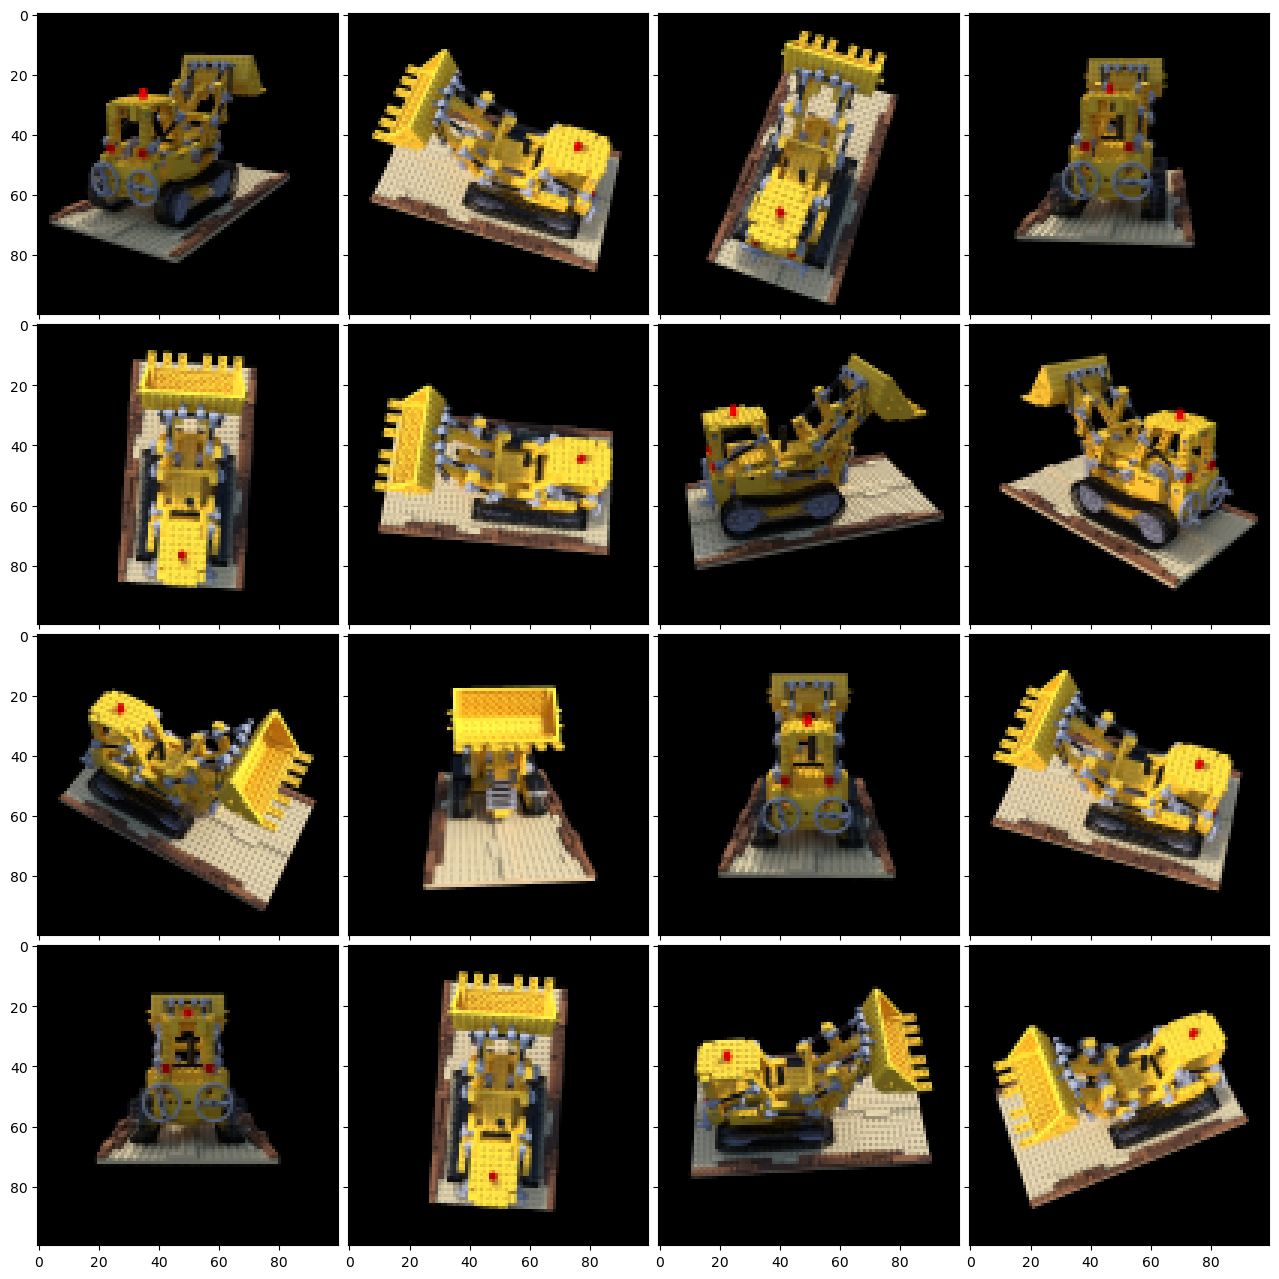

In [8]:
fig = plt.figure(figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1)
random_images = images[np.random.choice(np.arange(images.shape[0]), 16)]
for ax, image in zip(grid, random_images):
    ax.imshow(image)
plt.title("Sample Images from Tiny-NeRF Data")
plt.show()

**View Synthesis using Volume Rendering**

In [9]:
def generate_rays(height, width, focal, pose):
    # Create a 2D rectangular grid for the rays corresponding to image dimensions
    i, j = np.meshgrid(np.arange(width), np.arange(height), indexing="xy")
    
    transformed_i = (i - width * 0.5) / focal # Normalize the x-axis coordinates
    transformed_j = -(j - height * 0.5) / focal # Normalize the y-axis coordinates
    k = -np.ones_like(i) # z-axis coordinates
    # Create the unit vectors corresponding to ray directions
    directions = np.stack([transformed_i, transformed_j, k], axis=-1)
    
    # Compute Origins and Directions for each ray
    camera_directions = directions[..., None, :] * pose[:3, :3]
    ray_directions = np.einsum("ijl,kl", directions, pose[:3, :3])
    ray_origins = np.broadcast_to(pose[:3, -1], ray_directions.shape)
    return np.stack([ray_origins, ray_directions])

def compute_3d_points(ray_origins, ray_directions, random_number_generator=None):
    """Compute 3d query points for volumetric rendering"""
    # Sample space to parametrically compute the ray points
    t_vals = np.linspace(config.near_bound, config.far_bound, config.num_sample_points)
    if random_number_generator is not None:
        # inject a uniform noise into the sample space to make it continuous
        t_shape = ray_origins.shape[:-1] + (config.num_sample_points,)
        noise = jax.random.uniform(
            random_number_generator, t_shape
        ) * (config.far_bound - config.near_bound) / config.num_sample_points
        t_vals = t_vals + noise
    
    # Compute the ray traversal points using r(t) = o + t * d
    ray_origins = ray_origins[..., None, :]
    ray_directions = ray_directions[..., None, :]
    t_vals_flat = t_vals[..., :, None]
    points = ray_origins + ray_directions * t_vals_flat
    return points, t_vals


def compute_radiance_field(model, points):
    """Compute Radiance Field"""
    # Perform forward propagation
    model_output = lax.map(model, jnp.reshape(points, [-1, config.batch_size, 3]))
    radiance_field = jnp.reshape(model_output, points.shape[:-1] + (4,))
    # Slice the model output
    opacities = nn.relu(radiance_field[..., 3])
    colors = nn.sigmoid(radiance_field[..., :3])
    return opacities, colors


def compute_adjacent_distances(t_vals, ray_directions):
    """Get distances between adjacent intervals along sample space"""
    distances = t_vals[..., 1:] - t_vals[..., :-1]
    distances = jnp.concatenate([
        distances, np.broadcast_to(
            [config.epsilon], distances[..., :1].shape
        )], axis=-1
    )
    # Multiply each distance by the norm of its corresponding direction ray
    # to convert to real world distance (accounts for non-unit directions)
    distances = distances * jnp.linalg.norm(ray_directions[..., None, :], axis=-1)
    return distances


def compute_weights(opacities, distances):
    """Compute weight for the RGB of each sample along each ray"""
    # Compute density from the opacity
    density = jnp.exp(-opacities * distances)
    alpha = 1.0 - density
    clipped_difference = jnp.clip(1.0 - alpha, 1e-10, 1.0)
    # A cumulative product is basically used to express the idea
    # of the ray not having reflected up to this sample yet
    transmittance = jnp.cumprod(
        jnp.concatenate([
            jnp.ones_like(clipped_difference[..., :1]),
            clipped_difference[..., :-1]], -1
        ), axis=-1
    )
    return alpha * transmittance

In [10]:
def perform_volume_rendering(model, ray_origins, ray_directions, random_number_generator=None):
    # Compute 3d query points
    points, t_vals = compute_3d_points(
        ray_origins, ray_directions, random_number_generator
    )

    # Get color and opacities from the model
    opacities, colors = compute_radiance_field(model, points)

    # Get distances between adjacent intervals along sample space
    distances = compute_adjacent_distances(t_vals, ray_directions)

    # Compute weight for the RGB of each sample along each ray
    weights = compute_weights(opacities, distances)

    # Compute weighted RGB color of each sample along each ray
    rgb_map = jnp.sum(weights[..., None] * colors, axis=-2)
    
    # Compute the estimated depth map
    depth_map = jnp.sum(weights * t_vals, axis=-1)
    
    # Sum of weights along each ray; the value is in [0, 1] up to numerical error
    acc_map = jnp.sum(weights, axis=-1)
    
    # Disparity map is basically the inverse of depth
    disparity_map = 1. / jnp.maximum(1e-10, depth_map / jnp.sum(weights, axis=-1))


    return rgb_map, depth_map, acc_map, disparity_map, opacities

**Training**

In [11]:
def train_step(state, batch, rng):
    """Train Step"""
    inputs, targets = batch

    def loss_fn(params):
        model_fn = lambda x: state.apply_fn({"params": params}, x)
        ray_origins, ray_directions = inputs
        rgb, *_ = perform_volume_rendering(
            model_fn, ray_origins, ray_directions, rng
        )
        return jnp.mean((rgb - targets) ** 2)

    train_loss, gradients = jax.value_and_grad(loss_fn)(state.params)
    gradients = lax.pmean(gradients, axis_name="batch")
    new_state = state.apply_gradients(grads=gradients)
    train_loss = jnp.mean(train_loss)
    train_psnr = -10.0 * jnp.log(train_loss) / jnp.log(10.0)
    return train_loss, train_psnr, new_state 


@jax.jit
def validation_step(state):
    """Test Step"""
    model_fn = lambda x: state.apply_fn({"params": state.params}, x)
    ray_origins, ray_directions = val_rays
    rgb, depth, *_ = perform_volume_rendering(
        model_fn, ray_origins, ray_directions
    )
    loss = jnp.mean((rgb - val_image) ** 2)
    psnr = -10.0 * jnp.log(loss) / jnp.log(10.0)
    return rgb, depth, psnr, loss

In [12]:
def train_and_evaluate(state, train_step_fn, validation_step_fn):
    train_loss_history, train_psnr_history = [], []
    val_loss_history, val_psnr_history = [], []
    
    for epoch in tqdm(range(config.train_epochs)):
        rng_index, rng_epoch = jax.random.split(jax.random.fold_in(rng, epoch))
        sharded_rngs = common_utils.shard_prng_key(rng_epoch)
        
        train_index = jax.random.randint(
            rng_index, (n_devices,), minval=0, maxval=len(train_rays)
        )
        train_batch = train_rays[tuple(train_index), ...], train_images[tuple(train_index), ...]
        train_loss, train_psnr, state = train_step_fn(state, train_batch, sharded_rngs)
        train_loss_history.append(np.asarray(np.mean(train_loss)))
        train_psnr_history.append(np.asarray(np.mean(train_psnr)))
        wandb.log({"Train Loss": np.asarray(np.mean(train_loss))}, step=epoch)
        wandb.log({"Train PSNR": np.asarray(np.mean(train_loss))}, step=epoch)
        
        validation_state = flax.jax_utils.unreplicate(state)
        rgb, depth, val_psnr, val_loss = validation_step_fn(validation_state)
        val_loss_history.append(np.asarray(val_loss))
        val_psnr_history.append(np.asarray(val_psnr))
        wandb.log({"Validation Loss": np.asarray(val_loss)}, step=epoch)
        wandb.log({"Validation PSNR": np.asarray(val_psnr)}, step=epoch)
        
        if epoch % config.plot_interval == 0:    
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
            ax1.imshow(rgb)
            ax1.set_title(f"Predicted RGB at Epoch {epoch}")
            ax1.axis("off")
            ax2.imshow(depth)
            ax2.set_title(f"Predicted Depth at Epoch {epoch}")
            ax2.axis("off")
            plt.show()
            
    
    inference_state = flax.jax_utils.unreplicate(state)
    history = {
        "train_loss": train_loss_history,
        "train_psnr": train_psnr_history,
        "val_loss": val_loss_history,
        "val_psnr": val_psnr_history
    }
    return state, inference_state, history

In [13]:
# Parallelize the train step function by applying the composable transform `jax.pmap`
parallelized_train_step = jax.pmap(train_step, axis_name="batch")

train_rays = np.stack(list(map(
    lambda x: generate_rays(image_height, image_width, focal, x), train_poses
)))
val_rays = generate_rays(image_height, image_width, focal, val_pose)

n_devices = jax.local_device_count()
key, rng = jax.random.split(jax.random.PRNGKey(0))

model, params = initialize_model(key, (image_height * image_width, 3))
optimizer = optax.adam(learning_rate=config.learning_rate)
state = train_state.TrainState.create(
    apply_fn=model.apply, params=params, tx=optimizer
)
state = jax.device_put_replicated(state, jax.local_devices())

  0%|          | 0/1000 [00:00<?, ?it/s]

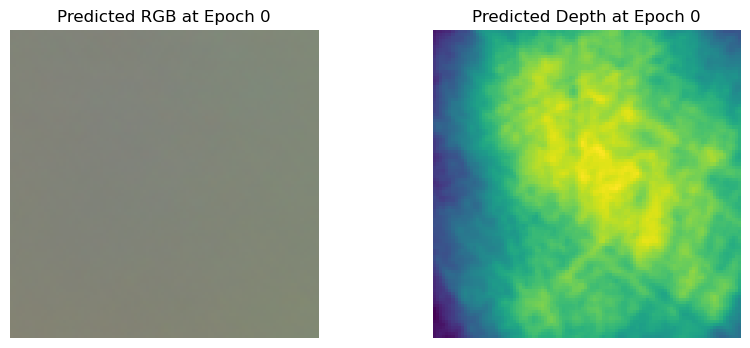

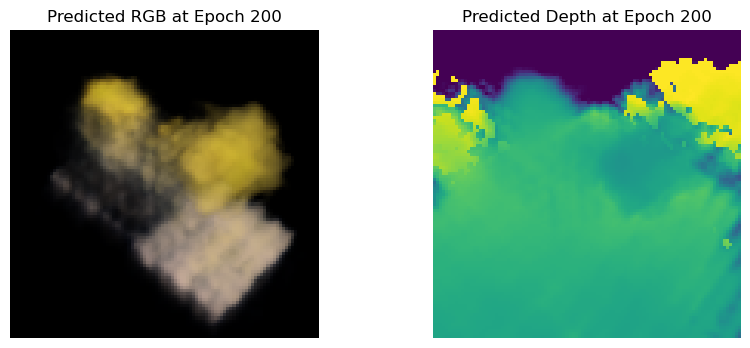

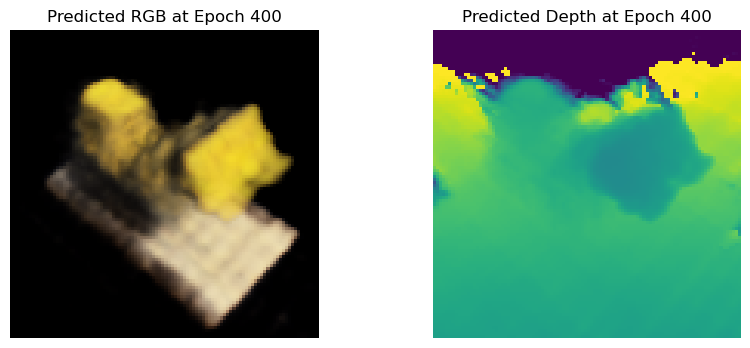

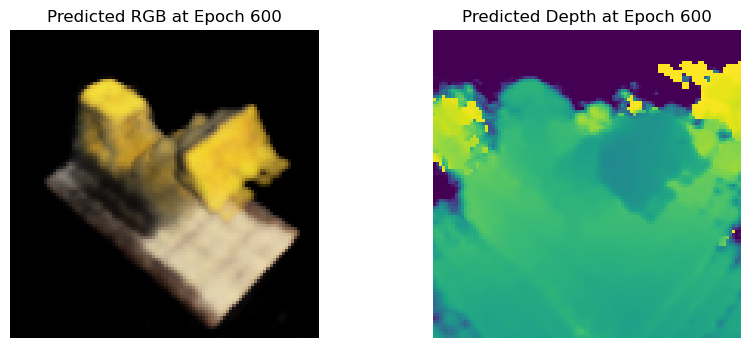

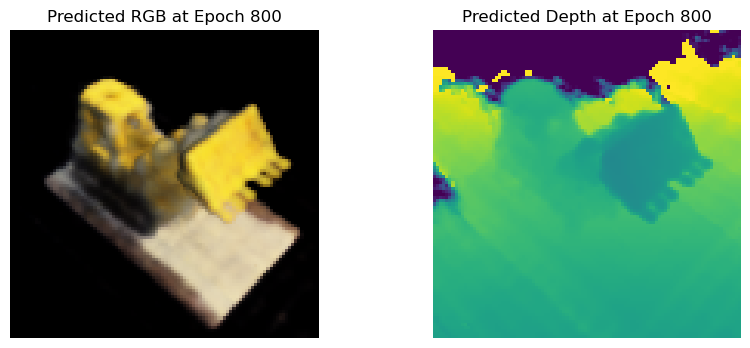

In [14]:
state, inference_state, history = train_and_evaluate(
    state, parallelized_train_step, validation_step
)

**Results**

In [15]:
def plot_result(history, item):
    train_item = "train_" + item
    val_item = "val_" + item
    plt.plot(history[train_item], label=train_item)
    plt.plot(history[val_item], label=val_item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

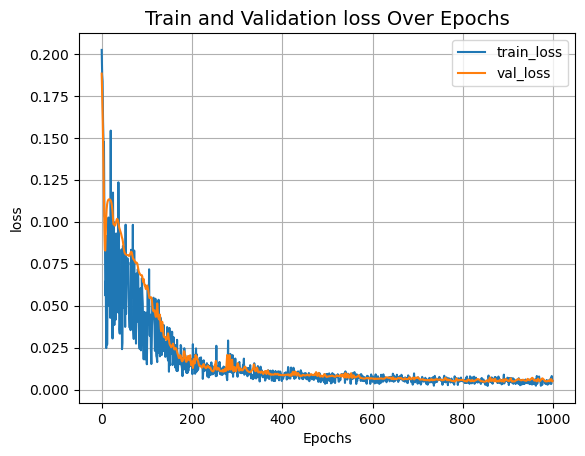

In [16]:
plot_result(history, "loss")

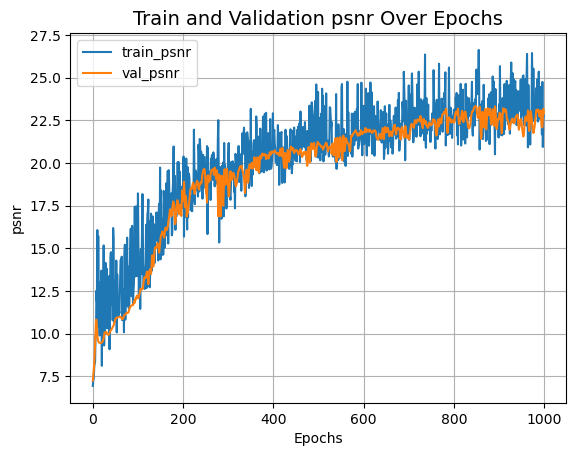

In [17]:
plot_result(history, "psnr")

In [18]:
def get_translation_matrix(t):
    return np.asarray(
        [
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, t],
            [0, 0, 0, 1],
        ]
    )

def get_rotation_matrix_phi(phi):
    return np.asarray(
        [
            [1, 0, 0, 0],
            [0, np.cos(phi), -np.sin(phi), 0],
            [0, np.sin(phi), np.cos(phi), 0],
            [0, 0, 0, 1],
        ]
    )

def get_rotation_matrix_theta(theta):
    return np.asarray(
        [
            [np.cos(theta), 0, -np.sin(theta), 0],
            [0, 1, 0, 0],
            [np.sin(theta), 0, np.cos(theta), 0],
            [0, 0, 0, 1],
        ]
    )


def pose_spherical(theta, phi, radius):
    camera_to_world_transform = get_translation_matrix(radius)
    camera_to_world_transform = get_rotation_matrix_phi(phi / 180.0 * np.pi) @ camera_to_world_transform
    camera_to_world_transform = get_rotation_matrix_theta(theta / 180.0 * np.pi) @ camera_to_world_transform
    camera_to_world_transform = np.array([
        [-1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1]
    ]) @ camera_to_world_transform
    return camera_to_world_transform


@jax.jit
def get_renderings(rays):
    model_fn = lambda x: inference_state.apply_fn(
        {"params": inference_state.params}, x
    )
    ray_origins, ray_directions = rays
    rgb, depth, acc, disparity, opacities = perform_volume_rendering(
        model_fn, ray_origins, ray_directions
    )
    img = (255 * jnp.clip(rgb, 0, 1)).astype(jnp.uint8)
    return img, depth, acc, disparity, opacities


def get_frames():
    video_angle = jnp.linspace(0.0, 360.0, 120, endpoint=False)
    camera_to_world_transform = map(lambda th: pose_spherical(th, -30.0, 4.0), video_angle)
    rays = np.stack(list(map(
        lambda x: generate_rays(
            image_height, image_width, focal, x[:3, :4]
        ), camera_to_world_transform
    )))
    rgb_frames, depth_frames, acc_maps, disparity_maps, opacities = lax.map(get_renderings, rays)
    rgb_frames = np.asarray(rgb_frames)
    depth_frames = np.asarray(depth_frames)
    acc_maps = np.asarray(acc_maps * 255.)
    disparity_maps = np.asarray(disparity_maps * 255.)
    return rgb_frames, depth_frames, acc_maps, disparity_maps

In [19]:
%%capture

rgb_frames, depth_frames, acc_maps, disparity_maps = get_frames()

imageio.mimwrite("rgb_video.mp4", tuple(rgb_frames), fps=30, quality=7)
imageio.mimwrite("depth_video.mp4", tuple(depth_frames), fps=30, quality=7)
imageio.mimwrite("acc_video.mp4", tuple(acc_maps), fps=30, quality=7)
imageio.mimwrite("disparity_video.mp4", tuple(disparity_maps), fps=30, quality=7)

wandb.log({"RGB Rendering": wandb.Video("rgb_video.mp4", fps=30, format="gif")})
wandb.log({"Depth Rendering": wandb.Video("depth_video.mp4", fps=30, format="gif")})
wandb.log({"Accuracy Rendering": wandb.Video("acc_video.mp4", fps=30, format="gif")})
wandb.log({"Disparity Map Rendering": wandb.Video("disparity_video.mp4", fps=30, format="gif")})

[swscaler @ 0x7322140] Warning: data is not aligned! This can lead to a speed loss
[swscaler @ 0x727e9c0] Warning: data is not aligned! This can lead to a speed loss
[swscaler @ 0x5de99c0] Warning: data is not aligned! This can lead to a speed loss
[swscaler @ 0x625f9c0] Warning: data is not aligned! This can lead to a speed loss



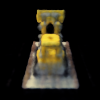
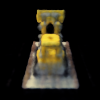
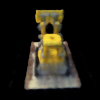
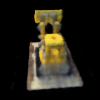
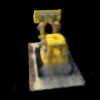
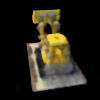
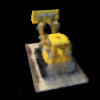
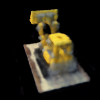
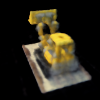
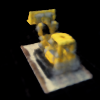
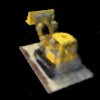
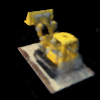
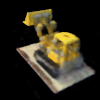
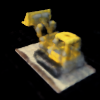
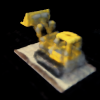
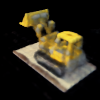
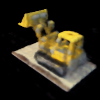
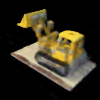
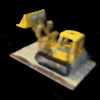
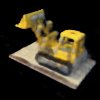
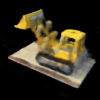
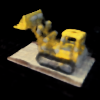
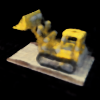
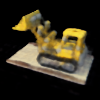
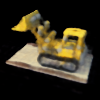
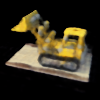
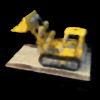
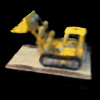
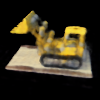
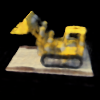
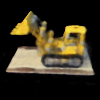
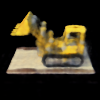
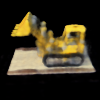
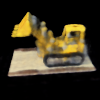
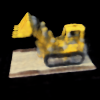
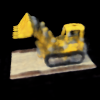
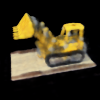
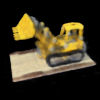
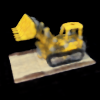
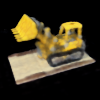
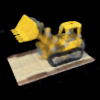
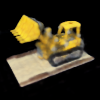
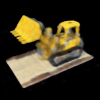
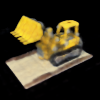
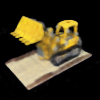
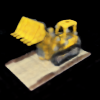
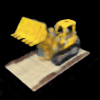
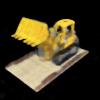
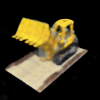
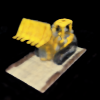
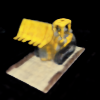
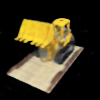
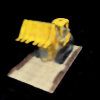
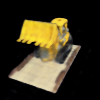
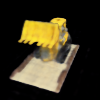
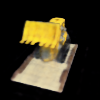
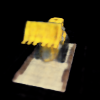
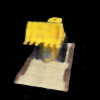
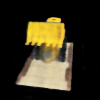
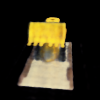
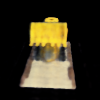
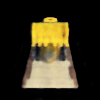
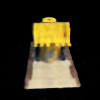
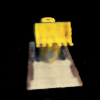
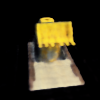
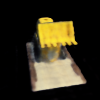
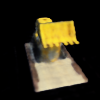
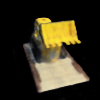
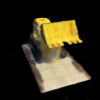
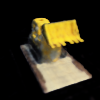
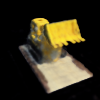
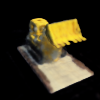
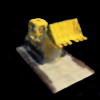
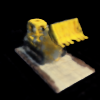
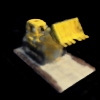
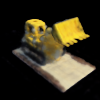
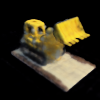
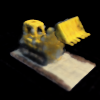
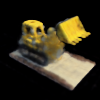
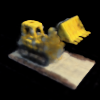
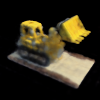
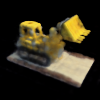
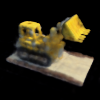
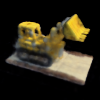
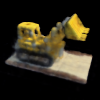
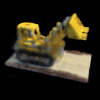
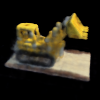
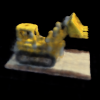
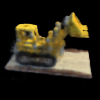
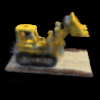
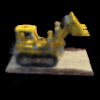
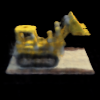
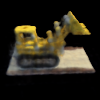
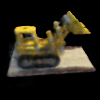
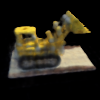
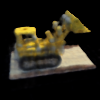
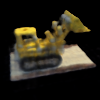
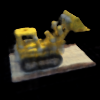
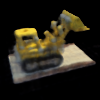
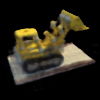
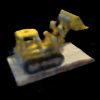
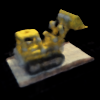
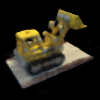
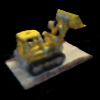
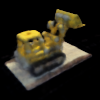
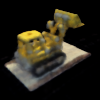
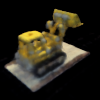
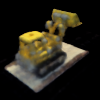
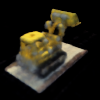
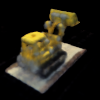
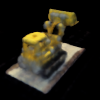
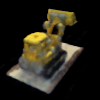
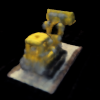
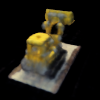
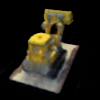
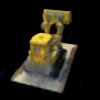
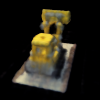
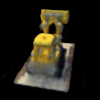
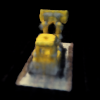
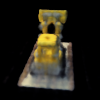
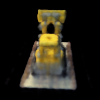

In [20]:
fig = px.imshow(
    rgb_frames,
    animation_frame=0,
    binary_string=True,
    labels=dict(animation_frame="slice")
)
fig.update_layout(title="RGB Reconstruction")
wandb.log({"RGB Reconstruction": fig})
fig.show()


In [21]:
mp4_file = open("rgb_video.mp4", "rb").read()
data_url = f"data:video/mp4;base64,{b64encode(mp4_file).decode()}"
HTML(
    """
<video width=500 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
"""
    % data_url
)

**Depth Map**


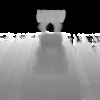
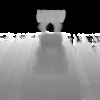
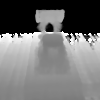
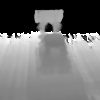
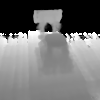
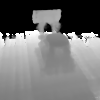
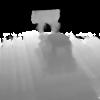
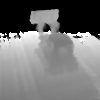
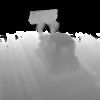
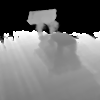
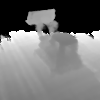
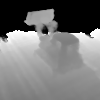
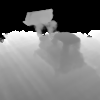
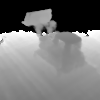
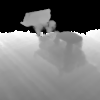
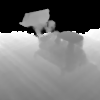
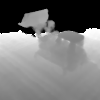
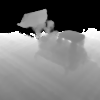
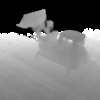
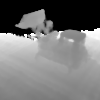
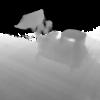
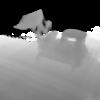
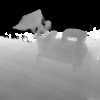
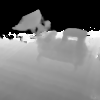
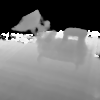
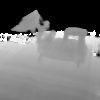
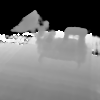
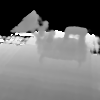
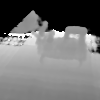
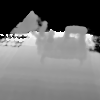
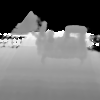
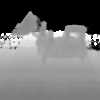
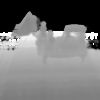
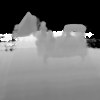
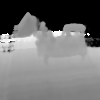
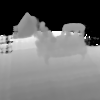
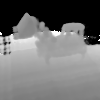
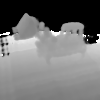
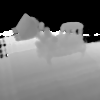
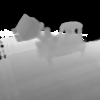
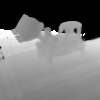
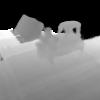
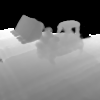
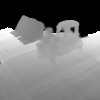
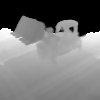
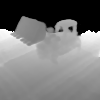
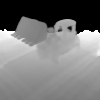
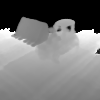
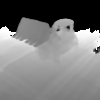
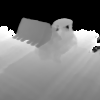
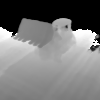
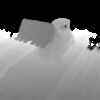
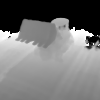
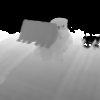
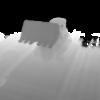
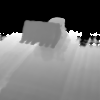
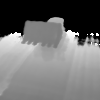
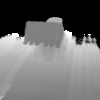
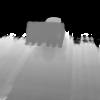
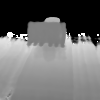
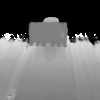
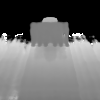
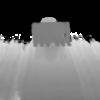
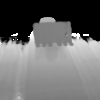
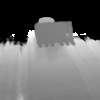
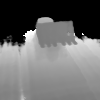
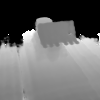
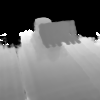
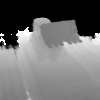
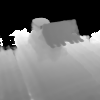
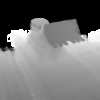
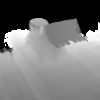
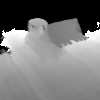
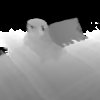
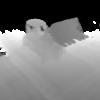
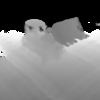
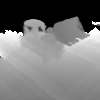
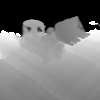
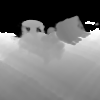
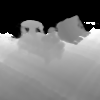
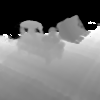
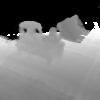
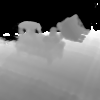
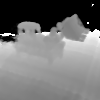
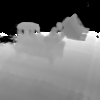
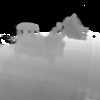
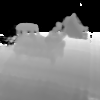
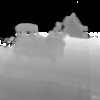
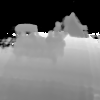
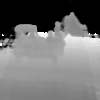
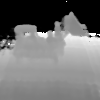
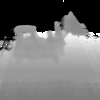
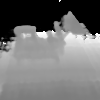
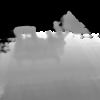
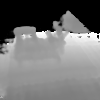
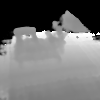
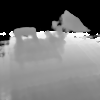
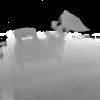
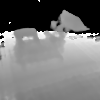
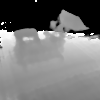
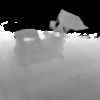
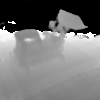
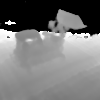
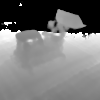
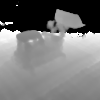
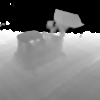
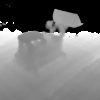
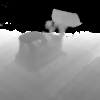
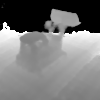
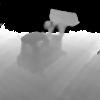
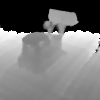
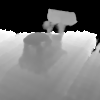
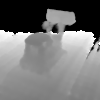
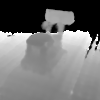
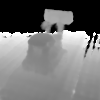
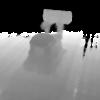
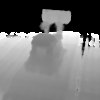
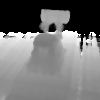
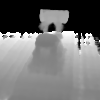
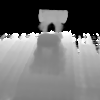
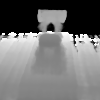

In [22]:
fig = px.imshow(
    depth_frames,
    animation_frame=0,
    binary_string=True,
    labels=dict(animation_frame="slice")
)
fig.update_layout(title="Depthmap Reconstruction")
wandb.log({"Depthmap Reconstruction": fig})
fig.show()

In [23]:
mp4_file = open("depth_video.mp4", "rb").read()
data_url = f"data:video/mp4;base64,{b64encode(mp4_file).decode()}"
HTML(
    """
<video width=500 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
"""
    % data_url
)

In [24]:
wandb.finish()

Train Loss,█▄▅▄▄▄▃▃▁▂▁▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train PSNR,█▄▅▄▄▄▃▃▁▂▁▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,▇█▇▆▅▄▃▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation PSNR,▁▁▁▂▂▃▄▄▅▆▆▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████▇█
Train Loss,0.00528
Train PSNR,0.00528
Validation Loss,0.00512
Validation PSNR,22.90771
